# Ripley on sphere
---
Tobias Stål, 2022

In [384]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [385]:
def distance(lat1, lon1, lat2, lon2, factor = 111.11111):
    '''
    Haversine formula returns distance between pairs of coordinates.
    coordinates as numpy arrays, lists or real
    factor : 111.1111 to convert distance to km 
    '''
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    
    a = 0.5 - np.cos((lat2-lat1))/2 + np.cos(lat1)*np.cos(lat2) * (1-np.cos((lon2-lon1))) / 2
    return np.rad2deg(2 * np.arcsin(np.sqrt(a))) * factor


def obs_area(t, radius=6_371, factor = 111.1111111):
    '''
    Spherical cap surface area
    t = arc distance
    radious of sphere
    '''
    return 2* np.pi * radius**2 * (1 - np.cos(np.deg2rad(t)/factor))

In [386]:
# Earth
r = 6_371
A = 4 * np.pi * r**2

In [387]:
# t values to evaluate in kilomtres
T = np.linspace(0, 180, 101)*111.11111



OBS_A = obs_area(T)

print(T[0], '-', T[-1], 'km')

print(OBS_A[0], '-', OBS_A[-1], 'km2')

0.0 - 19999.999799999998 km
0.0 - 510064471.90978813 km2


Text(0, 0.5, 'Area (km$^2$)')

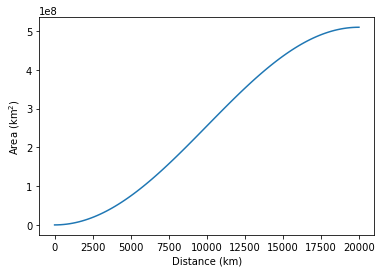

In [388]:
plt.plot(T,  obs_area(T))
plt.xlabel('Distance (km)')
plt.ylabel('Area (km$^2$)')

In [403]:
# Some example data
lats = np.array([0, 0, 0, 12, 12, 142, 12, 32, -22, 0, 0, 5, 5])
lons = np.array([0, 0.5, 1, 5, 6, 120, -230, 12, 56, 0, 180, 0, 180])


n= np.shape(lats)[0]

In [391]:
def make_dist_list(lats, lons):
    
    assert np.shape(lats) == np.shape(lons), 'lons and lats must have same shape'
    n = np.shape(lats)[0]

    lats = np.meshgrid(lats, lats)
    lons = np.meshgrid(lons, lons)

    mask = np.tril(np.ones((n,n)), k=-1).astype('bool') #mask the triangular matrix, exclude diagonal 

    dists = distance(lats[0][mask].flatten(), lons[0][mask].flatten(), 
                 lats[1][mask].flatten(), lons[1][mask].flatten())

    return np.sort(dists)


dists = make_dist_list(lats, lons)


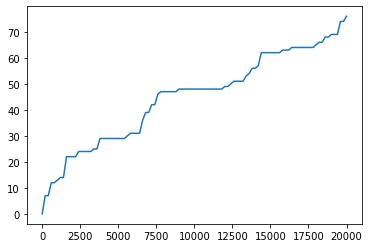

In [393]:
# Plot number of pairs 
N = np.sum(dists[:, None] < T, axis=0)

plt.plot(T, N)

In [443]:
T = np.linspace(0, 180, 1001)*111.1111111

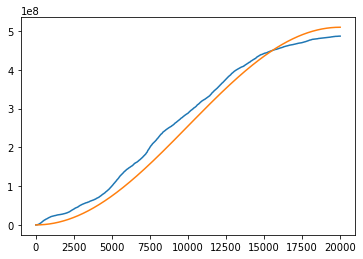

In [444]:
# Normalise to density

dists = make_dist_list(lats, lons)
K = A /(n*n) * 2 * np.sum(dists[:, None] < T, axis=0) 
R = obs_area(T)


plt.plot(T, K)
plt.plot(T, R)

In [445]:
def fibonacci_lattice(n = 300):

    goldenRatio = (1 + 5**0.5)/2
    i = np.arange(0, n)
    theta = 2 * np.pi * i / goldenRatio
    phi = np.arccos(1 - 2*(i+0.5)/n)

    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)

    lats = np.rad2deg(np.arctan2(z, np.sqrt(x**2 + y**2)))  
    lons = np.rad2deg(np.arctan2(y,x))       
    
    return lats, lons



def random_sphere(n=300):
    x = np.random.normal(0,1,(n,3)) 
    z = np.linalg.norm(x, axis=1) 
    z = z.reshape(-1,1).repeat(x.shape[1], axis=1) 
    x/z * np.sqrt(3) 
    
    np.shape(x/z * np.sqrt(3) )
    
    xyz =  x/z * np.sqrt(3)
    
    
    lats = np.rad2deg(np.arctan2(xyz[:,2], np.sqrt(xyz[:,0]**2 + xyz[:,1]**2)))  
    lons = np.rad2deg(np.arctan2(xyz[:,1],xyz[:,0]))   
    return lats, lons



def make_clusters(n = 300, points_in_each = 6, sigma = 3, f_seeds = fibonacci_lattice):
    
    n_clusters = n//points_in_each
    
    
    lats_seeds, lons_seeds =  f_seeds(n_clusters)
    
    lats = np.zeros((n_clusters, points_in_each))
    lons = np.zeros((n_clusters, points_in_each))
    
    
    for i in range(n_clusters):
        lats[i,:] = np.random.normal(lats_seeds[i], sigma, points_in_each)
        lons[i,:] = np.random.normal(lons_seeds[i], sigma, points_in_each)
    return np.clip(lats.flatten(), -90, 90), (((lons.flatten() + 180) % 360) - 180)

    
def bad_sampling(n = 300):
    return np.random.uniform(-90, 90, n), np.random.uniform(-180, 180, n)



In [455]:
def add_ripley(lats, lons, a):

    axins = inset_axes(a, 
                   width="100%", 
                   height="100%",
                   bbox_to_anchor=(1.3, 0.1, 0.7, 0.8),
                   bbox_transform=a.transAxes, 
                   borderpad=0.0)
  
    dists = make_dist_list(lats, lons)
    K = A /(n*n) * 2 * np.sum(dists[:, None] < T, axis=0) 
    R = obs_area(T)
    
    axins.plot(T, K-R)
    
    axins.set_ylim(-2e7, 2e7)
    
    axins.set_xlabel('Distance (km)')
    axins.set_ylabel('K(t) (Balanced)')
    
    axins.axhline(y=0, color='orange', linestyle='-', alpha = 0.5)
    
    #axins.plot(T, R)

/var/folders/qj/ml59kc_s28x7rs26r4ds8mzr0000gn/T/ipykernel_10073/2318627892.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


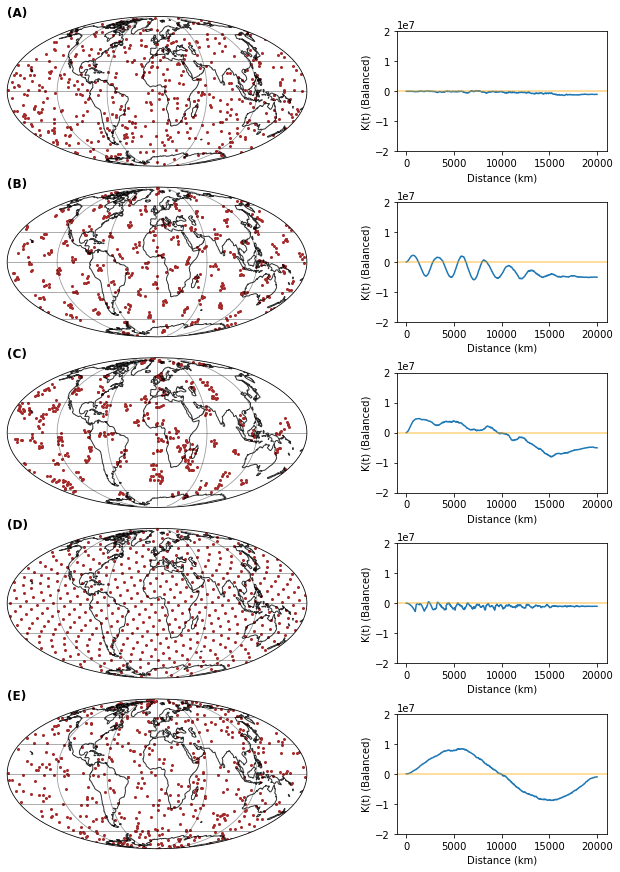

In [459]:
fig, ax = plt.subplots(5,1, 
                       figsize = (8,12), 
                       subplot_kw = dict(projection=ccrs.Mollweide()) )


n = 500

for label, a in zip(list('ABCDE'), ax.flatten()):
    a.text(0, 1, '(%s)'%label,transform=a.transAxes, 
        fontsize = 'large', 
        fontweight = 'bold')
    a.coastlines(resolution='auto', 
                 color='k', 
                 alpha = 0.8)
    a.gridlines(color='k', 
                linestyle='-', 
                draw_labels=False, 
                alpha = 0.4)
    a.set_global()
  



lats, lons = random_sphere(n)  
ax[0].scatter(lons, lats,
                color = 'brown',
                s = 4,
                transform = ccrs.PlateCarree())

    
add_ripley(lats, lons, ax[0])
    
    
    
lats, lons = make_clusters(n)  
ax[1].scatter(lons, lats,
                color = 'brown',
                s = 4,
                transform = ccrs.PlateCarree())

add_ripley(lats, lons, ax[1])
    
    
    
lats, lons = make_clusters(n, f_seeds = random_sphere)  
ax[2].scatter(lons, lats,
                color = 'brown',
                s = 4,
                transform = ccrs.PlateCarree())
    
add_ripley(lats, lons, ax[2])   
    
    
lats, lons = fibonacci_lattice(n)  
ax[3].scatter(lons, lats,
                color = 'brown',
                s = 4,
                transform = ccrs.PlateCarree())
    
 
add_ripley(lats, lons, ax[3])

   
lats, lons = bad_sampling(n)  
ax[4].scatter(lons, lats,
                color = 'brown',
                s = 4,
                transform = ccrs.PlateCarree())
    
add_ripley(lats, lons, ax[4])   





fig.tight_layout()
fig.savefig('fig/fig_1.pdf', dpi = 300, bbox_inches='tight')

In [460]:
! rsync -avhP fig /Users/tobias_stal/Dropbox/Apps/Overleaf/ripley\ non\ euclidian

building file list ... 
5 files to consider
fig/fig_1.pdf
     347.35K 100%  300.01MB/s    0:00:00 (xfer#1, to-check=3/5)

sent 347.59K bytes  received 42 bytes  695.26K bytes/sec
total size is 1.70M  speedup is 4.90
